# Import all the packages used

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.data import Dataset
import vampnet

import psutil
import gc

print(tf.__version__)
from vampnet import data_generator as vamp_data_generator
from tensorflow.contrib.keras.api.keras.models import Model
from tensorflow.contrib.keras.api.keras.layers import Dense, Activation, Flatten, Input, BatchNormalization, concatenate
from tensorflow.contrib.keras.api.keras.optimizers import Adam

import matplotlib.gridspec as gridspec
from tensorflow.contrib.keras.api.keras.backend import clear_session

import psutil

gc.enable()

1.15.0


In [4]:
! free -g

               total        used        free      shared  buff/cache   available
Mem:              15           3           2           0          10          11
Swap:              0           0           0


# Define Hyperparameters

In [5]:
# Tau, how much is the timeshift of the two datasets
tau = 1

# Batch size for Stochastic Gradient descent
batch_size = 1000 #1000

# Which trajectory points percentage is used as training
train_ratio = 0.9

# How many hidden layers the network has
network_depth = 5

# Width of every layer
layer_width = 250 #250 for E10, 5000 for P10

layer_width_factor = 3/4

# Learning rate used for the ADAM optimizer
learning_rate = 1e-4

# How many output states the network has
output_size = 2

# Iteration over the training set in the fitting process
nb_epoch = 300 #10

epsilon = 1e-5

dump_period=1000
picoseconds_per_step = 0.01  * dump_period # ps


model_name = str(output_size) + "_states_" + "E10_peptides_input_"

# Get train data

In [6]:
T = 365
data_serie = 0

path_to_raw_coords = "/localscratch/tuchkovy/peptide_condensate/npy/E10/"

In [30]:
from os import walk

coords_files = []
for (dirpath, dirnames, filenames) in walk(path_to_raw_coords):
    coords_files.extend(filenames)
    break
    
coords_files = [coords_files[-3]]
coords_files

['coords365K_75_1_0__0.npy']

0 , coords365K_75_1_0__0.npy
(4212, 12235)


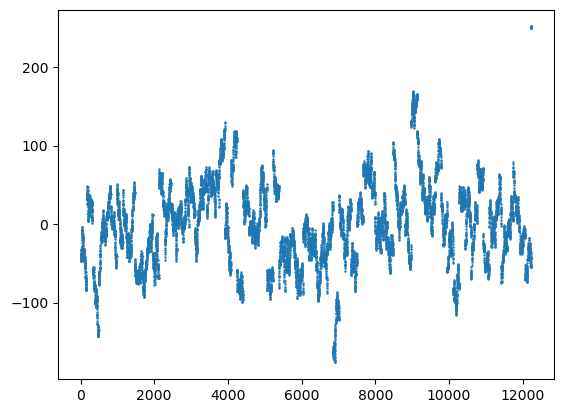

In [31]:
concatenation_points = np.array([], dtype=np.uint32)
count_files = 0
for file_name in coords_files:
    file_snapshots_amount = np.load(path_to_raw_coords + file_name).shape[0]
    if(count_files > 0):
        concatenation_points = np.append(concatenation_points, file_snapshots_amount + concatenation_points[count_files - 1])
    else:
        concatenation_points = np.append(concatenation_points, file_snapshots_amount)
        
    print(count_files, ",", file_name)
    count_files += 1

concatenation_points -= 1    # get indexes
concatenation_points = np.delete(concatenation_points, -1)

raw_coords = np.concatenate( [np.load(path_to_raw_coords + coords_files[i]).astype(np.float16) for i in range(len(coords_files))] )
#raw_coords = np.load(path_to_raw_coords + 'coords365K_75_1_0__0.npy')
#concatenation_points = np.array([])

raw_z_coords = raw_coords[:, :, 2]

snapshots = raw_coords.shape[0]
atoms = raw_coords.shape[1]
test_raw_z_coords = raw_coords[:, :, 2::3].reshape(snapshots, atoms)

print(raw_z_coords.shape)
plt.plot(raw_z_coords[0], '.', markersize=1.5);

## Detecting condensate's borders

In [35]:
windows_amounts = int(1000)
extra_space = 1.25
coord_min = np.min(raw_z_coords, axis = -1) * extra_space
coord_max = np.max(raw_z_coords, axis = -1) * extra_space
window_width = (coord_max - coord_min) / float(windows_amounts)

def concentration_from_coords(particles_positions):
    quantized_coords = np.zeros([snapshots, atoms])
    concentration = np.zeros([snapshots, windows_amounts])    
    bins_left_border = np.linspace(coord_min, coord_max, windows_amounts).T
    unique_quantized_coords = []
    concentration = []

    for frame in range(snapshots):
        quantized_coords[frame] = ((raw_z_coords[frame, :]) // window_width[frame]).astype(int)    
        this_frame_unique_quantized_coords, this_frame_concentration = np.unique(quantized_coords[frame], return_counts=True)

        unique_quantized_coords.append(this_frame_unique_quantized_coords)
        concentration.append(this_frame_concentration)
        
    return (unique_quantized_coords, concentration)

# returns nparray with components of left and right border z-coordinate
def detect_condensate_edges(quantized_coords, concentration, threshold_normalized = 0.1):
    borders = np.zeros([snapshots, 2])
    
    conc = concentration
    #print(np.max(conc) * threshold_normalized)
    conc[conc >= np.max(conc) * threshold_normalized] = 0
    
    n = 10
    # n maximum velues
    borders = quantized_coords[(-conc).argsort()[:n]]
    coords_range = np.max(quantized_coords) - np.min(quantized_coords)
    #print(borders)
    while(np.abs(borders[1] - borders[0]) < coords_range * 0.1 and borders.shape[-1] > 2):
        borders = np.delete(borders, 1)
    #print(borders)
    if(borders.shape[-1] >= 2): return borders[:2]
    else: return None
    
    
'''
# CONDENSATE'S BORDERS DETECTION TEST
test_frame = 500
dots = 10

print("borders: ", borders[test_frame])
plt.plot(raw_z_coords[test_frame], '.', markersize = 1.5)
plt.plot(np.linspace(0, atoms, dots), np.repeat(borders[test_frame][0], dots), color='red');
plt.plot(np.linspace(0, atoms, dots), np.repeat(borders[test_frame][1], dots), color='red');'''

'\n# CONDENSATE\'S BORDERS DETECTION TEST\ntest_frame = 500\ndots = 10\n\nprint("borders: ", borders[test_frame])\nplt.plot(raw_z_coords[test_frame], \'.\', markersize = 1.5)\nplt.plot(np.linspace(0, atoms, dots), np.repeat(borders[test_frame][0], dots), color=\'red\');\nplt.plot(np.linspace(0, atoms, dots), np.repeat(borders[test_frame][1], dots), color=\'red\');'

## Training data:
- 10 * 3 numbers: coordinates of every single peptide particle
- 3 numbers: left, right condensate border, threashold

In [36]:
peptide_atoms = 10
#condensate_border_threshold

peptide_coords = raw_coords[:, -peptide_atoms:, :].reshape(snapshots, peptide_atoms * 3);

unique_quantized_coords, concentration = concentration_from_coords(raw_z_coords)    #for all frames    
condensate_border_threshold = 0.25
borders = np.zeros([snapshots, 2])

for frame in range(snapshots):
    thisframe_borders = detect_condensate_edges(unique_quantized_coords[frame], concentration[frame], threshold_normalized = condensate_border_threshold)
    borders[frame] = thisframe_borders * window_width[frame]

    
#condensate_threshold_array = np.repeat(condensate_border_threshold, snapshots).reshape(snapshots, 1)
peptide_coords = np.abs(peptide_coords)
traj_whole = peptide_coords.reshape(snapshots, peptide_atoms * 3) #np.concatenate((peptide_coords, borders), axis = 1)
traj_data_points, input_size = traj_whole.shape

# Initialized the VAMPnets wrapper class

In [37]:
vamp = vampnet.VampnetTools(epsilon = epsilon)

# Shuffle trajectory and lagged trajectory together

In [38]:
length_data = traj_data_points - tau

traj_ord = traj_whole[:length_data, ...]
traj_ord_lag = traj_whole[tau:length_data+tau, ...]

traj_ord = np.delete(traj_ord, concatenation_points, axis = 0)
traj_ord_lag = np.delete(traj_ord_lag, concatenation_points, axis = 0)

length_data -= concatenation_points.size

indexes = np.arange(length_data)
np.random.shuffle(indexes)

traj = traj_ord[indexes]
traj_lag = traj_ord_lag[indexes]

# Prepare data for tensorflow usage

In [39]:
length_train = int(np.floor(length_data * train_ratio))
length_vali = length_data - length_train

traj_data_train = traj[:length_train]
traj_data_train_lag = traj_lag[:length_train]

traj_data_valid = traj[length_train:]
traj_data_valid_lag = traj_lag[length_train:]

# Input of the first network
X1_train = traj_data_train.astype('float32')
X2_train  = traj_data_train_lag.astype('float32')

# Input for validation
X1_vali = traj_data_valid.astype('float32')
X2_vali = traj_data_valid_lag.astype('float32')

# Needs a Y-train set which we dont have.
Y_train = np.zeros((length_train,2*output_size)).astype('float32')
Y_vali = np.zeros((length_vali,2*output_size)).astype('float32')

gc.collect()

34171

In [40]:
# Build the model

def generate_nodes():
    return [layer_width * layer_width_factor**i for i in range(network_depth)]

nodes = generate_nodes()

Data_X = Input(shape = (input_size,))
Data_Y = Input(shape = (input_size,))

# A batch normalization layer improves convergence speed
bn_layer = BatchNormalization()

# Instance layers and assign them to the two lobes of the network
dense_layers = [Dense(node, activation = 'elu')# if index_layer < 3 else 'linear nodes')
                for index_layer,node in enumerate(nodes)]

lx_branch = bn_layer(Data_X)
rx_branch = bn_layer(Data_Y)

for i, layer in enumerate(dense_layers):

    lx_branch = dense_layers[i](lx_branch)
    rx_branch = dense_layers[i](rx_branch)


# Add a softmax output layer.
# Should be replaced with a linear activation layer if
# the outputs of the network cannot be interpreted as states
softmax = Dense(output_size, activation='softmax')

lx_branch = softmax(lx_branch)
rx_branch = softmax(rx_branch)

# Merge both networks to train both at the same time
merged = concatenate([lx_branch, rx_branch])

# Initialize the model and the optimizer, and compile it with
# the loss and metric functions from the VAMPnets package
model = Model(inputs = [Data_X, Data_Y], outputs = merged)

model.summary()

gc.collect()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30)           120         input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 250)          7750        batch_normalization_1[0][0]

132

# Run several model iterations saving the best one, to help finding sparcely populated states

In [13]:
#from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.python.keras.callbacks import CSVLogger

checkpoint_path = "model_checkpoints/"

csv_logger = CSVLogger(model_name + 'log.csv', append=True, separator=';')

my_callbacks = [
    csv_logger,
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=2)
]

max_vm = 0
attempts = 3
found_better_weights = 0

# IMPORTANT: the function vamp.loss_VAMP2_autograd can only be used with tensorflow 1.6 or more recent.
# For older versions of TF, use the function vamp.loss_VAMP2

losses = [
    vamp.loss_VAMP2_autograd,
]


for i in range(attempts):    
    print("Attempt", i)
    # Clear the previous tensorflow session to prevent memory leaks
    clear_session()

    # Build the model


    nodes = generate_nodes() #[layer_width]*network_depth

    Data_X = Input(shape = (input_size,))
    Data_Y = Input(shape = (input_size,))

    # A batch normalization layer improves convergence speed
    bn_layer = BatchNormalization()

    # Instance layers and assign them to the two lobes of the network
    dense_layers = [Dense(node, activation = 'elu')# if index_layer < 3 else 'linear nodes')
                    for index_layer,node in enumerate(nodes)]

    lx_branch = bn_layer(Data_X)
    rx_branch = bn_layer(Data_Y)

    for i, layer in enumerate(dense_layers):
        
        lx_branch = dense_layers[i](lx_branch)
        rx_branch = dense_layers[i](rx_branch)


    # Add a softmax output layer.
    # Should be replaced with a linear activation layer if
    # the outputs of the network cannot be interpreted as states
    softmax = Dense(output_size, activation='softmax')

    lx_branch = softmax(lx_branch)
    rx_branch = softmax(rx_branch)

    # Merge both networks to train both at the same time
    merged = concatenate([lx_branch, rx_branch])

    # Initialize the model and the optimizer, and compile it with
    # the loss and metric functions from the VAMPnets package
    model = Model(inputs = [Data_X, Data_Y], outputs = merged)
    adam = Adam(lr = learning_rate/10)

    vm1 = np.zeros((len(losses), nb_epoch))
    tm1 = np.zeros_like(vm1)
    vm2 = np.zeros_like(vm1)
    tm2 = np.zeros_like(vm1)
    vm3 = np.zeros_like(vm1)
    tm3 = np.zeros_like(vm1)

    for l_index, loss_function in enumerate(losses):
        
        model.compile(optimizer = adam,
                      loss = loss_function,
                      metrics = [
                          vamp.metric_VAMP,
                          vamp.metric_VAMP2,
                                 ])
        
        # Train the model
        print("Started training model.")        
        gc.collect()
        
        hist = model.fit([X1_train, X2_train], Y_train ,
                         #batch_size=batch_size,
                         epochs=nb_epoch,
                         validation_data=([X1_vali, X2_vali], Y_vali ),
                         verbose=1, callbacks=my_callbacks)

        gc.collect()

        vm1[l_index] = np.array(hist.history['val_metric_VAMP'])
        tm1[l_index] = np.array(hist.history['metric_VAMP'])


        vm2[l_index] = np.array(hist.history['val_metric_VAMP2'])
        tm2[l_index] = np.array(hist.history['metric_VAMP2'])

        vm3[l_index] = np.array(hist.history['val_loss'])
        tm3[l_index] = np.array(hist.history['loss'])


    vm1 = np.reshape(vm1, (-1))
    tm1 = np.reshape(tm1, (-1))
    vm2 = np.reshape(vm2, (-1))
    tm2 = np.reshape(tm2, (-1))
    vm3 = np.reshape(vm3, (-1))
    tm3 = np.reshape(tm3, (-1))

    # Average the score obtained in the last part of the training process
    # in order to estabilish which model is better and thus worth saving


    score = vm1[-5:].mean()
    extra_msg = ''
    if score > max_vm:
        found_better_weights += 1
        extra_msg = ' - Highest'
        best_weights = model.get_weights()
        np.save("weights/" + model_name, best_weights, allow_pickle=True)
        max_vm = score
        vm1_max = vm1
        tm1_max = tm1
        vm2_max = vm2
        tm2_max = tm2
        vm3_max = vm3
        tm3_max = tm3

    print('Score: {0:.2f}'.format(score) + extra_msg)
    gc.collect()

Attempt 0
Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use `tf.cast` instead.


Started training model.
Train on 3645 samples, validate on 405 samples


2022-10-31 17:53:41.728231: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 17:53:41.753373: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3000000000 Hz
2022-10-31 17:53:41.753969: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c7777bb6a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-10-31 17:53:41.754009: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-7
OMP: Info #156: KMP_AFFINITY

Epoch 1/300
1120/3645 [========>.....................] - ETA: 2s - loss: -0.7698 - metric_VAMP: 0.8716 - metric_VAMP2: 0.7698 

OMP: Info #250: KMP_AFFINITY: pid 25654 tid 25708 thread 1 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 25654 tid 25709 thread 2 bound to OS proc set 2
OMP: Info #250: KMP_AFFINITY: pid 25654 tid 25713 thread 3 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 25654 tid 25714 thread 4 bound to OS proc set 4
OMP: Info #250: KMP_AFFINITY: pid 25654 tid 25715 thread 5 bound to OS proc set 5
OMP: Info #250: KMP_AFFINITY: pid 25654 tid 25716 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 25654 tid 25717 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 25654 tid 25718 thread 8 bound to OS proc set 0
OMP: Info #250: KMP_AFFINITY: pid 25654 tid 25719 thread 9 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 25654 tid 25720 thread 10 bound to OS proc set 2
OMP: Info #250: KMP_AFFINITY: pid 25654 tid 25721 thread 11 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 25654 tid 25722 thread 12 bound to OS proc set 4
OMP: Info #25

3616/3645 [============================>.] - ETA: 0s - loss: -0.8921 - metric_VAMP: 0.9416 - metric_VAMP2: 0.8921
Epoch 00001: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 2s 508us/sample - loss: -0.8928 - metric_VAMP: 0.9420 - metric_VAMP2: 0.8928 - val_loss: -0.9564 - val_metric_VAMP: 0.9780 - val_metric_VAMP2: 0.9565
Epoch 2/300
3168/3645 [=========================>....] - ETA: 0s - loss: -0.9746 - metric_VAMP: 0.9872 - metric_VAMP2: 0.9746
Epoch 00002: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9752 - metric_VAMP: 0.9875 - metric_VAMP2: 0.9752 - val_loss: -0.9800 - val_metric_VAMP: 0.9899 - val_metric_VAMP2: 0.9800
Epoch 3/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9839 - metric_VAMP: 0.9919 - metric_VAMP2: 0.9839
Epoch 00003: saving model to model_c

Epoch 12/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9934 - metric_VAMP: 0.9967 - metric_VAMP2: 0.9934
Epoch 00012: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 145us/sample - loss: -0.9934 - metric_VAMP: 0.9967 - metric_VAMP2: 0.9934 - val_loss: -0.9928 - val_metric_VAMP: 0.9964 - val_metric_VAMP2: 0.9928
Epoch 13/300
3296/3645 [==========================>...] - ETA: 0s - loss: -0.9937 - metric_VAMP: 0.9968 - metric_VAMP2: 0.9937
Epoch 00013: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 148us/sample - loss: -0.9936 - metric_VAMP: 0.9968 - metric_VAMP2: 0.9936 - val_loss: -0.9927 - val_metric_VAMP: 0.9964 - val_metric_VAMP2: 0.9927
Epoch 14/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9937 - metric_VAMP: 0.9969 - metric_VAMP2: 0.9937
Epoch 00014: saving m

Epoch 23/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9948 - metric_VAMP: 0.9974 - metric_VAMP2: 0.9948
Epoch 00023: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 140us/sample - loss: -0.9948 - metric_VAMP: 0.9974 - metric_VAMP2: 0.9948 - val_loss: -0.9941 - val_metric_VAMP: 0.9971 - val_metric_VAMP2: 0.9942
Epoch 24/300
3328/3645 [==========================>...] - ETA: 0s - loss: -0.9949 - metric_VAMP: 0.9974 - metric_VAMP2: 0.9949
Epoch 00024: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 130us/sample - loss: -0.9949 - metric_VAMP: 0.9974 - metric_VAMP2: 0.9949 - val_loss: -0.9944 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9944
Epoch 25/300
3232/3645 [=========================>....] - ETA: 0s - loss: -0.9951 - metric_VAMP: 0.9975 - metric_VAMP2: 0.9951
Epoch 00025: saving m

Epoch 34/300
3424/3645 [===========================>..] - ETA: 0s - loss: -0.9953 - metric_VAMP: 0.9976 - metric_VAMP2: 0.9953
Epoch 00034: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 145us/sample - loss: -0.9954 - metric_VAMP: 0.9977 - metric_VAMP2: 0.9954 - val_loss: -0.9938 - val_metric_VAMP: 0.9969 - val_metric_VAMP2: 0.9938
Epoch 35/300
3296/3645 [==========================>...] - ETA: 0s - loss: -0.9956 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9956
Epoch 00035: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 133us/sample - loss: -0.9955 - metric_VAMP: 0.9977 - metric_VAMP2: 0.9955 - val_loss: -0.9945 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9945
Epoch 36/300
3328/3645 [==========================>...] - ETA: 0s - loss: -0.9956 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9956
Epoch 00036: saving m

Epoch 45/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9955 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9955
Epoch 00045: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 130us/sample - loss: -0.9955 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9955 - val_loss: -0.9946 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9947
Epoch 46/300
3232/3645 [=========================>....] - ETA: 0s - loss: -0.9955 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9955
Epoch 00046: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 139us/sample - loss: -0.9956 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9956 - val_loss: -0.9945 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9946
Epoch 47/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9957 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9957
Epoch 00047: saving m

Epoch 56/300
3104/3645 [========================>.....] - ETA: 0s - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958
Epoch 00056: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 138us/sample - loss: -0.9957 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9957 - val_loss: -0.9945 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9943
Epoch 57/300
3232/3645 [=========================>....] - ETA: 0s - loss: -0.9955 - metric_VAMP: 0.9977 - metric_VAMP2: 0.9955
Epoch 00057: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 150us/sample - loss: -0.9956 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9956 - val_loss: -0.9948 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9948
Epoch 58/300
3616/3645 [============================>.] - ETA: 0s - loss: -0.9955 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9955
Epoch 00058: saving m

Epoch 67/300
3488/3645 [===========================>..] - ETA: 0s - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958
Epoch 00067: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 146us/sample - loss: -0.9957 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9957 - val_loss: -0.9946 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9946
Epoch 68/300
3616/3645 [============================>.] - ETA: 0s - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958
Epoch 00068: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958 - val_loss: -0.9946 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9945
Epoch 69/300
3232/3645 [=========================>....] - ETA: 0s - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958
Epoch 00069: saving m

Epoch 78/300
3424/3645 [===========================>..] - ETA: 0s - loss: -0.9956 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9956
Epoch 00078: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 130us/sample - loss: -0.9957 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9957 - val_loss: -0.9944 - val_metric_VAMP: 0.9971 - val_metric_VAMP2: 0.9942
Epoch 79/300
3392/3645 [==========================>...] - ETA: 0s - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958
Epoch 00079: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 134us/sample - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958 - val_loss: -0.9945 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9946
Epoch 80/300
3200/3645 [=========================>....] - ETA: 0s - loss: -0.9959 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9959
Epoch 00080: saving m

Epoch 89/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9959 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9959
Epoch 00089: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 124us/sample - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958 - val_loss: -0.9948 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9949
Epoch 90/300
3232/3645 [=========================>....] - ETA: 0s - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960
Epoch 00090: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 135us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9943 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9944
Epoch 91/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960
Epoch 00091: saving m

Epoch 100/300
3520/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00100: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 128us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9947 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9948
Epoch 101/300
3520/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00101: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 147us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9944 - val_metric_VAMP: 0.9970 - val_metric_VAMP2: 0.9939
Epoch 102/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00102: savin

Epoch 111/300
3168/3645 [=========================>....] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00111: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9947 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9947
Epoch 112/300
3616/3645 [============================>.] - ETA: 0s - loss: -0.9959 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9959
Epoch 00112: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9959 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9959 - val_loss: -0.9946 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9945
Epoch 113/300
3392/3645 [==========================>...] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00113: savin

Epoch 122/300
3488/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00122: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 144us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9947 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9947
Epoch 123/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960
Epoch 00123: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9949 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9949
Epoch 124/300
3264/3645 [=========================>....] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00124: savin

Epoch 133/300
3264/3645 [=========================>....] - ETA: 0s - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960
Epoch 00133: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 135us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9948 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9948
Epoch 134/300
3616/3645 [============================>.] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00134: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 142us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9944 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9944
Epoch 135/300
3328/3645 [==========================>...] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00135: savin

Epoch 144/300
3200/3645 [=========================>....] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00144: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 137us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9944 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9945
Epoch 145/300
3616/3645 [============================>.] - ETA: 0s - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960
Epoch 00145: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 140us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9946 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9944
Epoch 146/300
3424/3645 [===========================>..] - ETA: 0s - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960
Epoch 00146: savin

Epoch 155/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00155: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 144us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9946 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9946
Epoch 156/300
3200/3645 [=========================>....] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00156: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 137us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9949 - val_metric_VAMP: 0.9975 - val_metric_VAMP2: 0.9949
Epoch 157/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00157: savin

Epoch 166/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00166: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 146us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9947 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9947
Epoch 167/300
3488/3645 [===========================>..] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00167: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 149us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9948 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9948
Epoch 168/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00168: savin

Epoch 177/300
3296/3645 [==========================>...] - ETA: 0s - loss: -0.9959 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9959
Epoch 00177: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9943 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9943
Epoch 178/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00178: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 142us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9948 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9948
Epoch 179/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00179: savin

Epoch 188/300
3520/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00188: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 140us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9949 - val_metric_VAMP: 0.9975 - val_metric_VAMP2: 0.9950
Epoch 189/300
3168/3645 [=========================>....] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00189: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 136us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9947 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9944
Epoch 190/300
3424/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00190: savin

Epoch 199/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00199: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 142us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9947 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9948
Epoch 200/300
3296/3645 [==========================>...] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00200: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 131us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9945 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9945
Epoch 201/300
3520/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00201: savin

Epoch 210/300
3392/3645 [==========================>...] - ETA: 0s - loss: -0.9963 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9963
Epoch 00210: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 132us/sample - loss: -0.9963 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9963 - val_loss: -0.9948 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9948
Epoch 211/300
3424/3645 [===========================>..] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00211: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 144us/sample - loss: -0.9963 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9963 - val_loss: -0.9946 - val_metric_VAMP: 0.9971 - val_metric_VAMP2: 0.9943
Epoch 212/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00212: savin

Epoch 221/300
3520/3645 [===========================>..] - ETA: 0s - loss: -0.9963 - metric_VAMP: 0.9982 - metric_VAMP2: 0.9963
Epoch 00221: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 143us/sample - loss: -0.9963 - metric_VAMP: 0.9982 - metric_VAMP2: 0.9963 - val_loss: -0.9949 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9949
Epoch 222/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9963 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9963
Epoch 00222: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 144us/sample - loss: -0.9963 - metric_VAMP: 0.9982 - metric_VAMP2: 0.9963 - val_loss: -0.9942 - val_metric_VAMP: 0.9971 - val_metric_VAMP2: 0.9943
Epoch 223/300
3488/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00223: savin

Epoch 232/300
3360/3645 [==========================>...] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00232: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 136us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9950 - val_metric_VAMP: 0.9975 - val_metric_VAMP2: 0.9950
Epoch 233/300
3616/3645 [============================>.] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00233: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9946 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9945
Epoch 234/300
3104/3645 [========================>.....] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00234: savin

Epoch 243/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00243: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 144us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9945 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9946
Epoch 244/300
3424/3645 [===========================>..] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00244: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 145us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9946 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9946
Epoch 245/300
3616/3645 [============================>.] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00245: savin

Epoch 254/300
3104/3645 [========================>.....] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00254: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9944 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9945
Epoch 255/300
3424/3645 [===========================>..] - ETA: 0s - loss: -0.9963 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9963
Epoch 00255: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 151us/sample - loss: -0.9963 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9963 - val_loss: -0.9943 - val_metric_VAMP: 0.9971 - val_metric_VAMP2: 0.9942
Epoch 256/300
3488/3645 [===========================>..] - ETA: 0s - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960
Epoch 00256: savin

Epoch 265/300
3296/3645 [==========================>...] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00265: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 217us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9947 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9945
Epoch 266/300
3488/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00266: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9948 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9948
Epoch 267/300
3456/3645 [===========================>..] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00267: savin

Epoch 276/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00276: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 137us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9947 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9948
Epoch 277/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00277: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 138us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9947 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9947
Epoch 278/300
3264/3645 [=========================>....] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00278: savin

Epoch 287/300
3168/3645 [=========================>....] - ETA: 0s - loss: -0.9963 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9963
Epoch 00287: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 138us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9948 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9949
Epoch 288/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9963 - metric_VAMP: 0.9982 - metric_VAMP2: 0.9963
Epoch 00288: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 147us/sample - loss: -0.9963 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9963 - val_loss: -0.9945 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9946
Epoch 289/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00289: savin

Epoch 298/300
3424/3645 [===========================>..] - ETA: 0s - loss: -0.9963 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9963
Epoch 00298: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 148us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9947 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9947
Epoch 299/300
3296/3645 [==========================>...] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00299: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 137us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9943 - val_metric_VAMP: 0.9971 - val_metric_VAMP2: 0.9943
Epoch 300/300
3488/3645 [===========================>..] - ETA: 0s - loss: -0.9963 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9963
Epoch 00300: savin

/uni-mainz.de/homes/tuchkovy/miniconda3/envs/tfenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Attempt 1
Started training model.
Train on 3645 samples, validate on 405 samples
Epoch 1/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.8970 - metric_VAMP: 0.9444 - metric_VAMP2: 0.8970
Epoch 00001: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 2s 451us/sample - loss: -0.9069 - metric_VAMP: 0.9500 - metric_VAMP2: 0.9070 - val_loss: -0.9682 - val_metric_VAMP: 0.9838 - val_metric_VAMP2: 0.9679
Epoch 2/300
3456/3645 [===========================>..] - ETA: 0s - loss: -0.9750 - metric_VAMP: 0.9874 - metric_VAMP2: 0.9750
Epoch 00002: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 145us/sample - loss: -0.9751 - metric_VAMP: 0.9875 - metric_VAMP2: 0.9751 - val_loss: -0.9767 - val_metric_VAMP: 0.9883 - val_metric_VAMP2: 0.9768
Epoch 3/300
3520/3645 [===========================>..] - ETA: 0s - lo

3645/3645 [==============================] - 1s 145us/sample - loss: -0.9922 - metric_VAMP: 0.9961 - metric_VAMP2: 0.9922 - val_loss: -0.9901 - val_metric_VAMP: 0.9950 - val_metric_VAMP2: 0.9900
Epoch 12/300
3360/3645 [==========================>...] - ETA: 0s - loss: -0.9926 - metric_VAMP: 0.9963 - metric_VAMP2: 0.9926
Epoch 00012: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 136us/sample - loss: -0.9926 - metric_VAMP: 0.9963 - metric_VAMP2: 0.9926 - val_loss: -0.9911 - val_metric_VAMP: 0.9956 - val_metric_VAMP2: 0.9913
Epoch 13/300
3328/3645 [==========================>...] - ETA: 0s - loss: -0.9929 - metric_VAMP: 0.9964 - metric_VAMP2: 0.9929
Epoch 00013: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 173us/sample - loss: -0.9929 - metric_VAMP: 0.9964 - metric_VAMP2: 0.9929 - val_loss: -0.9914 - val_

3645/3645 [==============================] - 1s 140us/sample - loss: -0.9945 - metric_VAMP: 0.9973 - metric_VAMP2: 0.9945 - val_loss: -0.9930 - val_metric_VAMP: 0.9964 - val_metric_VAMP2: 0.9929
Epoch 23/300
3360/3645 [==========================>...] - ETA: 0s - loss: -0.9948 - metric_VAMP: 0.9974 - metric_VAMP2: 0.9948
Epoch 00023: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 147us/sample - loss: -0.9947 - metric_VAMP: 0.9974 - metric_VAMP2: 0.9947 - val_loss: -0.9930 - val_metric_VAMP: 0.9965 - val_metric_VAMP2: 0.9930
Epoch 24/300
3488/3645 [===========================>..] - ETA: 0s - loss: -0.9947 - metric_VAMP: 0.9974 - metric_VAMP2: 0.9947
Epoch 00024: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 144us/sample - loss: -0.9947 - metric_VAMP: 0.9974 - metric_VAMP2: 0.9947 - val_loss: -0.9930 - val_

3645/3645 [==============================] - 1s 140us/sample - loss: -0.9954 - metric_VAMP: 0.9977 - metric_VAMP2: 0.9954 - val_loss: -0.9937 - val_metric_VAMP: 0.9969 - val_metric_VAMP2: 0.9938
Epoch 34/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9952 - metric_VAMP: 0.9976 - metric_VAMP2: 0.9952
Epoch 00034: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 139us/sample - loss: -0.9953 - metric_VAMP: 0.9976 - metric_VAMP2: 0.9953 - val_loss: -0.9942 - val_metric_VAMP: 0.9971 - val_metric_VAMP2: 0.9942
Epoch 35/300
3232/3645 [=========================>....] - ETA: 0s - loss: -0.9950 - metric_VAMP: 0.9975 - metric_VAMP2: 0.9950
Epoch 00035: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 138us/sample - loss: -0.9950 - metric_VAMP: 0.9975 - metric_VAMP2: 0.9950 - val_loss: -0.9939 - val_

3645/3645 [==============================] - 0s 129us/sample - loss: -0.9954 - metric_VAMP: 0.9977 - metric_VAMP2: 0.9954 - val_loss: -0.9940 - val_metric_VAMP: 0.9970 - val_metric_VAMP2: 0.9940
Epoch 45/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9954 - metric_VAMP: 0.9977 - metric_VAMP2: 0.9954
Epoch 00045: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9954 - metric_VAMP: 0.9977 - metric_VAMP2: 0.9954 - val_loss: -0.9935 - val_metric_VAMP: 0.9967 - val_metric_VAMP2: 0.9934
Epoch 46/300
3616/3645 [============================>.] - ETA: 0s - loss: -0.9955 - metric_VAMP: 0.9977 - metric_VAMP2: 0.9955
Epoch 00046: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 140us/sample - loss: -0.9955 - metric_VAMP: 0.9977 - metric_VAMP2: 0.9955 - val_loss: -0.9942 - val_

3645/3645 [==============================] - 0s 136us/sample - loss: -0.9959 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9959 - val_loss: -0.9940 - val_metric_VAMP: 0.9970 - val_metric_VAMP2: 0.9940
Epoch 56/300
3616/3645 [============================>.] - ETA: 0s - loss: -0.9956 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9956
Epoch 00056: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 140us/sample - loss: -0.9957 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9957 - val_loss: -0.9946 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9946
Epoch 57/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9957 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9957
Epoch 00057: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958 - val_loss: -0.9942 - val_

3645/3645 [==============================] - 0s 126us/sample - loss: -0.9957 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9957 - val_loss: -0.9943 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9944
Epoch 67/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9959 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9959
Epoch 00067: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9943 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9943
Epoch 68/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9956 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9956
Epoch 00068: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 148us/sample - loss: -0.9956 - metric_VAMP: 0.9978 - metric_VAMP2: 0.9956 - val_loss: -0.9945 - val_

3645/3645 [==============================] - 0s 124us/sample - loss: -0.9959 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9959 - val_loss: -0.9947 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9947
Epoch 78/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9957 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9957
Epoch 00078: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 221us/sample - loss: -0.9957 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9957 - val_loss: -0.9943 - val_metric_VAMP: 0.9970 - val_metric_VAMP2: 0.9940
Epoch 79/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958
Epoch 00079: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 139us/sample - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958 - val_loss: -0.9947 - val_

3645/3645 [==============================] - 1s 142us/sample - loss: -0.9959 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9959 - val_loss: -0.9948 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9949
Epoch 89/300
3488/3645 [===========================>..] - ETA: 0s - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960
Epoch 00089: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 143us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9945 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9945
Epoch 90/300
3424/3645 [===========================>..] - ETA: 0s - loss: -0.9959 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9959
Epoch 00090: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 144us/sample - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958 - val_loss: -0.9944 - val_

3645/3645 [==============================] - 0s 134us/sample - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958 - val_loss: -0.9943 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9944
Epoch 100/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958
Epoch 00100: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 139us/sample - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958 - val_loss: -0.9944 - val_metric_VAMP: 0.9971 - val_metric_VAMP2: 0.9942
Epoch 101/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9959 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9959
Epoch 00101: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 142us/sample - loss: -0.9959 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9959 - val_loss: -0.9943 - va

3645/3645 [==============================] - 1s 146us/sample - loss: -0.9959 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9959 - val_loss: -0.9946 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9947
Epoch 111/300
3616/3645 [============================>.] - ETA: 0s - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960
Epoch 00111: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 143us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9945 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9945
Epoch 112/300
3616/3645 [============================>.] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00112: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 143us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9945 - va

3645/3645 [==============================] - 1s 139us/sample - loss: -0.9959 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9959 - val_loss: -0.9945 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9946
Epoch 122/300
3232/3645 [=========================>....] - ETA: 0s - loss: -0.9959 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9959
Epoch 00122: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 135us/sample - loss: -0.9959 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9959 - val_loss: -0.9948 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9949
Epoch 123/300
3616/3645 [============================>.] - ETA: 0s - loss: -0.9959 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9959
Epoch 00123: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9959 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9959 - val_loss: -0.9947 - va

3645/3645 [==============================] - 0s 136us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9948 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9949
Epoch 133/300
3456/3645 [===========================>..] - ETA: 0s - loss: -0.9959 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9959
Epoch 00133: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 145us/sample - loss: -0.9959 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9959 - val_loss: -0.9948 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9946
Epoch 134/300
3456/3645 [===========================>..] - ETA: 0s - loss: -0.9959 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9959
Epoch 00134: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 149us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9947 - va

3645/3645 [==============================] - 1s 144us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9947 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9948
Epoch 144/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00144: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 145us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9944 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9946
Epoch 145/300
3424/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00145: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 144us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9947 - va

3645/3645 [==============================] - 0s 137us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9949 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9949
Epoch 155/300
3168/3645 [=========================>....] - ETA: 0s - loss: -0.9958 - metric_VAMP: 0.9979 - metric_VAMP2: 0.9958
Epoch 00155: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 137us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9949 - val_metric_VAMP: 0.9975 - val_metric_VAMP2: 0.9949
Epoch 156/300
3456/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00156: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 131us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9945 - va

3645/3645 [==============================] - 1s 145us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9946 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9945
Epoch 166/300
3104/3645 [========================>.....] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00166: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 138us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9949 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9948
Epoch 167/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960
Epoch 00167: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 137us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9949 - va

3645/3645 [==============================] - 0s 136us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9947 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9947
Epoch 177/300
3168/3645 [=========================>....] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00177: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 135us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9948 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9947
Epoch 178/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9963 - metric_VAMP: 0.9982 - metric_VAMP2: 0.9963
Epoch 00178: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 149us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9945 - va

3645/3645 [==============================] - 1s 143us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9949 - val_metric_VAMP: 0.9975 - val_metric_VAMP2: 0.9949
Epoch 188/300
3520/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00188: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 147us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9945 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9945
Epoch 189/300
3232/3645 [=========================>....] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00189: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 135us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9943 - va

3645/3645 [==============================] - 0s 133us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9945 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9944
Epoch 199/300
3424/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00199: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 148us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9947 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9947
Epoch 200/300
3360/3645 [==========================>...] - ETA: 0s - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960
Epoch 00200: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 147us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9946 - va

3645/3645 [==============================] - 1s 139us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9948 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9947
Epoch 210/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9959 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9959
Epoch 00210: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 138us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9947 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9948
Epoch 211/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960
Epoch 00211: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9946 - va

3645/3645 [==============================] - 0s 136us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9944 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9945
Epoch 221/300
3424/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00221: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 134us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9948 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9947
Epoch 222/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00222: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9948 - va

3645/3645 [==============================] - 1s 139us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9946 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9947
Epoch 232/300
3488/3645 [===========================>..] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00232: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 143us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9943 - val_metric_VAMP: 0.9971 - val_metric_VAMP2: 0.9941
Epoch 233/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00233: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 142us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9948 - va

3645/3645 [==============================] - 1s 140us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9945 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9945
Epoch 243/300
3392/3645 [==========================>...] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00243: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 147us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9948 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9947
Epoch 244/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00244: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 143us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9948 - va

3645/3645 [==============================] - 1s 138us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9944 - val_metric_VAMP: 0.9970 - val_metric_VAMP2: 0.9941
Epoch 254/300
3104/3645 [========================>.....] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00254: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 141us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9950 - val_metric_VAMP: 0.9975 - val_metric_VAMP2: 0.9950
Epoch 255/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00255: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 143us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9947 - va

3645/3645 [==============================] - 1s 144us/sample - loss: -0.9963 - metric_VAMP: 0.9982 - metric_VAMP2: 0.9963 - val_loss: -0.9946 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9947
Epoch 265/300
3232/3645 [=========================>....] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00265: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 145us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9949 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9949
Epoch 266/300
3488/3645 [===========================>..] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00266: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 142us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9944 - va

3645/3645 [==============================] - 1s 144us/sample - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961 - val_loss: -0.9947 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9947
Epoch 276/300
3552/3645 [============================>.] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961
Epoch 00276: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 145us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9948 - val_metric_VAMP: 0.9974 - val_metric_VAMP2: 0.9949
Epoch 277/300
3616/3645 [============================>.] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00277: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 139us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9944 - va

3645/3645 [==============================] - 1s 141us/sample - loss: -0.9960 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9960 - val_loss: -0.9944 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9945
Epoch 287/300
3360/3645 [==========================>...] - ETA: 0s - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962
Epoch 00287: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 155us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9944 - val_metric_VAMP: 0.9972 - val_metric_VAMP2: 0.9945
Epoch 288/300
3136/3645 [========================>.....] - ETA: 0s - loss: -0.9963 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9963
Epoch 00288: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 140us/sample - loss: -0.9962 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9962 - val_loss: -0.9947 - va

3645/3645 [==============================] - 1s 146us/sample - loss: -0.9963 - metric_VAMP: 0.9982 - metric_VAMP2: 0.9963 - val_loss: -0.9949 - val_metric_VAMP: 0.9975 - val_metric_VAMP2: 0.9949
Epoch 298/300
3296/3645 [==========================>...] - ETA: 0s - loss: -0.9963 - metric_VAMP: 0.9982 - metric_VAMP2: 0.9963
Epoch 00298: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 135us/sample - loss: -0.9963 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9963 - val_loss: -0.9946 - val_metric_VAMP: 0.9973 - val_metric_VAMP2: 0.9947
Epoch 299/300
3584/3645 [============================>.] - ETA: 0s - loss: -0.9961 - metric_VAMP: 0.9980 - metric_VAMP2: 0.9961
Epoch 00299: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 143us/sample - loss: -0.9961 - metric_VAMP: 0.9981 - metric_VAMP2: 0.9961 - val_loss: -0.9949 - va

/uni-mainz.de/homes/tuchkovy/miniconda3/envs/tfenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Attempt 2
Started training model.
Train on 3645 samples, validate on 405 samples
Epoch 1/300
3488/3645 [===========================>..] - ETA: 0s - loss: -0.9353 - metric_VAMP: 0.9659 - metric_VAMP2: 0.9353
Epoch 00001: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 2s 424us/sample - loss: -0.9369 - metric_VAMP: 0.9668 - metric_VAMP2: 0.9369 - val_loss: -0.9749 - val_metric_VAMP: 0.9871 - val_metric_VAMP2: 0.9745
Epoch 2/300
3296/3645 [==========================>...] - ETA: 0s - loss: -0.9803 - metric_VAMP: 0.9901 - metric_VAMP2: 0.9803
Epoch 00002: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 0s 133us/sample - loss: -0.9805 - metric_VAMP: 0.9902 - metric_VAMP2: 0.9805 - val_loss: -0.9832 - val_metric_VAMP: 0.9916 - val_metric_VAMP2: 0.9832
Epoch 3/300
3584/3645 [============================>.] - ETA: 0s - lo

3645/3645 [==============================] - 1s 147us/sample - loss: -0.9940 - metric_VAMP: 0.9970 - metric_VAMP2: 0.9940 - val_loss: -0.9925 - val_metric_VAMP: 0.9963 - val_metric_VAMP2: 0.9926
Epoch 12/300
3424/3645 [===========================>..] - ETA: 0s - loss: -0.9941 - metric_VAMP: 0.9970 - metric_VAMP2: 0.9941
Epoch 00012: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 146us/sample - loss: -0.9941 - metric_VAMP: 0.9970 - metric_VAMP2: 0.9941 - val_loss: -0.9929 - val_metric_VAMP: 0.9964 - val_metric_VAMP2: 0.9928
Epoch 13/300
3456/3645 [===========================>..] - ETA: 0s - loss: -0.9945 - metric_VAMP: 0.9973 - metric_VAMP2: 0.9945
Epoch 00013: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3645/3645 [==============================] - 1s 150us/sample - loss: -0.9946 - metric_VAMP: 0.9973 - metric_VAMP2: 0.9946 - val_loss: -0.9932 - val_

KeyboardInterrupt: 

In [40]:
gc.collect(generation=2)
max_vm

0.9973742485046386

In [59]:
! free -g

               total        used        free      shared  buff/cache   available
Mem:              15           5           5           0           3           9
Swap:              0           0           0


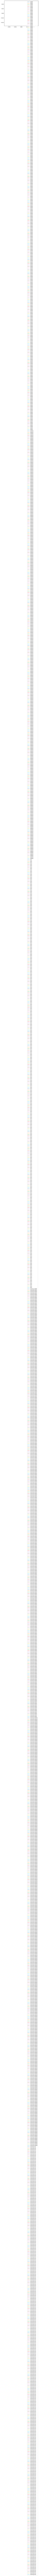

In [28]:
plt.plot(vm1, label = 'VAMP')
plt.plot(vm2, label = 'VAMP2')
plt.plot(-vm3, label = 'loss')
plt.plot(tm1, label = 'training VAMP')
plt.plot(tm2, label = 'training VAMP2')
plt.plot(-tm3, label = 'training loss')
plt.legend()
plt.savefig("losses.png")
plt.show()

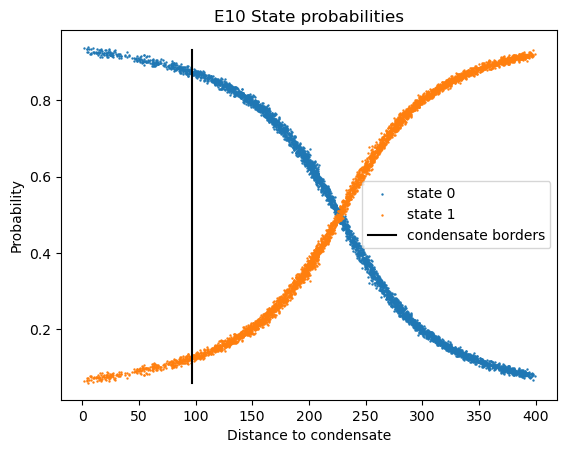

In [43]:
temp = model.predict([traj_ord, traj_ord_lag], batch_size=np.shape(X1_vali)[0])
    
x_a = temp[:,:output_size]

average_peptide_z = np.average((traj_ord)[:, :-3][:, 2::3], axis = 1)
average_condesate_width = np.average(np.abs(traj_ord[:, -1] - traj_ord[:, -2]))

plt.clf()
X_Validation = average_peptide_z
for i in range(output_size):
    plt.scatter(X_Validation, x_a[:,i], label= 'state '+str(i), s=0.5)
plt.title('E10 State probabilities')
plt.xlabel("Distance to condensate")
plt.ylabel("Probability")


# plot condensate borders
dots = 10
yline = np.linspace(np.min(x_a[:,i]), np.max(x_a[:,i]), dots)
#plt.plot(- np.repeat(average_condesate_width, dots)/ 2, yline, color = 'black')
plt.plot(+ np.repeat(average_condesate_width, dots)/ 2, yline, color = 'black', label= 'condensate borders')

plt.legend()
plt.show()

/uni-mainz.de/homes/tuchkovy/miniconda3/envs/tfenv/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


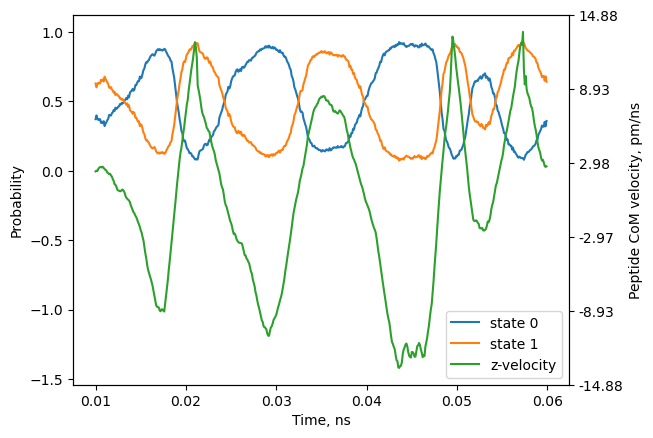

In [52]:
# Over time

test_snapshots = 500
state_probability = x_a[:test_snapshots,:]


fig, ax1 = plt.subplots()

## probability of frame (time)
#plt.clf()
for i in (range(output_size)):
    ax1.plot(np.arange(state_probability.shape[0]), state_probability[:, i], label= 'state '+str(i))

velocity_time_lag = 1
average_peptide_z_velocity = average_peptide_z[velocity_time_lag:] - average_peptide_z[:velocity_time_lag]

velocity_scale_factor = np.max(average_peptide_z_velocity)
average_peptide_z_velocity_normalized = average_peptide_z_velocity / velocity_scale_factor

ax1.plot(average_peptide_z_velocity_normalized[:test_snapshots], label = "z-velocity")      

ax1.xaxis.set_ticklabels(np.arange(state_probability.shape[0]) * picoseconds_per_step * 10**-3)
plt.xlabel("Time, ns")
plt.ylabel("Probability")

ax2 = ax1.twinx()
ax2.set_ylabel("Peptide CoM velocity, pm/ns")
ax2.set_ylim(0, 60)
ax2.set_yticks(np.linspace(0, 1, 6) * velocity_scale_factor)
ax2.set_yticklabels(np.round(np.linspace(-1, 1, 6) * velocity_scale_factor / picoseconds_per_step, 2))

ax1.legend()
plt.show()

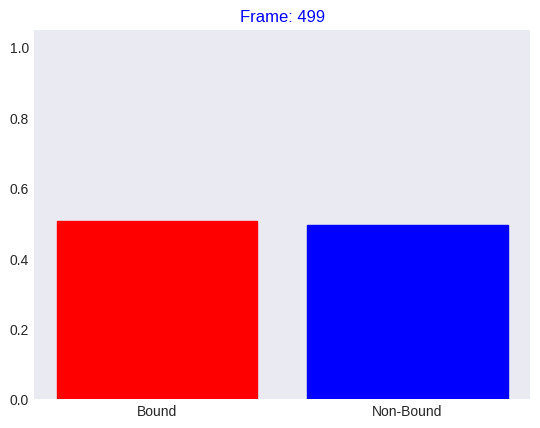

In [71]:
import matplotlib.pyplot as plt
from matplotlib import animation

plt.style.use("seaborn-dark")
test_snapshots = 500
state_probability = x_a[:test_snapshots,:]

def barlist(n): 
    return [1/float(n*k) for k in range(1,3)]

fig=plt.figure()

n=test_snapshots #Number of frames
x=range(2)
barcollection = plt.bar(x,barlist(1))
barcollection[0].set_color('r')
barcollection[1].set_color('b')

tick_lst = ["Bound", "Non-Bound"]

def animate(frame):
    y=[state_probability[frame, 0], state_probability[frame, 1]]
    for i, b in enumerate(barcollection):
        b.set_height(y[i])
        plt.xticks(np.arange(2), tick_lst)
        plt.title("Frame: " + str(frame), color=("blue"))

anim=animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=n,
                             interval=100)

anim.save('E10_coords365K_75_1_0__997150__9.mp4',writer=animation.FFMpegWriter(fps=13.4))
plt.show()

# Save model weights

In [22]:
best_weights = model.get_weights()
np.save("weights/" + model_name, best_weights, allow_pickle=True)

/uni-mainz.de/homes/tuchkovy/miniconda3/envs/tfenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Recover the saved model and its training history

In [42]:
#model.load_weights(checkpoint_path)                   #from checkpoint
weights = np.load("weights/" + model_name+ ".npy", allow_pickle=True) #.tolist()
model.set_weights((weights).tolist() )    #from nparray

In [42]:
weights_file_name = "best_weights"
found_better_weights = 0

max_vm = 0

# IMPORTANT: the function vamp.loss_VAMP2_autograd can only be used with tensorflow 1.6 or more recent.
# For older versions of TF, use the function vamp.loss_VAMP2

from tensorflow.python.keras.callbacks import CSVLogger

checkpoint_path = "model_checkpoints/"

csv_logger = CSVLogger(model_name + 'log.csv', append=True, separator=';')

my_callbacks = [
    csv_logger,
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=2)
]

################
# SETUP MODEL
################

# Clear the previous tensorflow session to prevent memory leaks
clear_session()

# Build the model


nodes = generate_nodes()

Data_X = Input(shape = (input_size,))
Data_Y = Input(shape = (input_size,))

# A batch normalization layer improves convergence speed
bn_layer = BatchNormalization()

# Instance layers and assign them to the two lobes of the network
dense_layers = [Dense(node, activation = 'elu')# if index_layer < 3 else 'linear nodes')
                for index_layer,node in enumerate(nodes)]

lx_branch = bn_layer(Data_X)
rx_branch = bn_layer(Data_Y)

for i, layer in enumerate(dense_layers):

    lx_branch = dense_layers[i](lx_branch)
    rx_branch = dense_layers[i](rx_branch)


# Add a softmax output layer.
# Should be replaced with a linear activation layer if
# the outputs of the network cannot be interpreted as states
softmax = Dense(output_size, activation='softmax')

lx_branch = softmax(lx_branch)
rx_branch = softmax(rx_branch)

# Merge both networks to train both at the same time
merged = concatenate([lx_branch, rx_branch])

# Initialize the model and the optimizer, and compile it with
# the loss and metric functions from the VAMPnets package
model = Model(inputs = [Data_X, Data_Y], outputs = merged)
adam = Adam(lr = learning_rate/10)

vm1 = np.zeros((len(losses), nb_epoch))
tm1 = np.zeros_like(vm1)
vm2 = np.zeros_like(vm1)
tm2 = np.zeros_like(vm1)
vm3 = np.zeros_like(vm1)
tm3 = np.zeros_like(vm1)

weights = np.load("weights/" + model_name+ ".npy", allow_pickle=True) #.tolist()
model.set_weights((weights).tolist() )    #from nparray


for l_index, loss_function in enumerate(losses):
        
    model.compile(optimizer = adam,
                  loss = loss_function,
                  metrics = [
                      vamp.metric_VAMP,
                      vamp.metric_VAMP2,
                             ])

    # Train the model
    print("Started training model.")        
    hist = model.fit([X1_train, X2_train], Y_train ,
                     #batch_size=batch_size,
                     epochs=nb_epoch,
                     validation_data=([X1_vali, X2_vali], Y_vali ),
                     verbose=1, callbacks=my_callbacks)


    vm1[l_index] = np.array(hist.history['val_metric_VAMP'])
    tm1[l_index] = np.array(hist.history['metric_VAMP'])


    vm2[l_index] = np.array(hist.history['val_metric_VAMP2'])
    tm2[l_index] = np.array(hist.history['metric_VAMP2'])

    vm3[l_index] = np.array(hist.history['val_loss'])
    tm3[l_index] = np.array(hist.history['loss'])


vm1 = np.reshape(vm1, (-1))
tm1 = np.reshape(tm1, (-1))
vm2 = np.reshape(vm2, (-1))
tm2 = np.reshape(tm2, (-1))
vm3 = np.reshape(vm3, (-1))
tm3 = np.reshape(tm3, (-1))

# Average the score obtained in the last part of the training process
# in order to estabilish which model is better and thus worth saving


score = vm1[-5:].mean()

best_weights = model.get_weights()
np.save("weights/" + model_name, best_weights, allow_pickle=True)

Started training model.
Train on 3636 samples, validate on 404 samples
Epoch 1/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9948 - metric_VAMP: 0.9974 - metric_VAMP2: 0.9948
Epoch 00001: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3636/3636 [==============================] - 39s 11ms/sample - loss: -0.9949 - metric_VAMP: 0.9974 - metric_VAMP2: 0.9949 - val_loss: -0.9974 - val_metric_VAMP: 0.9987 - val_metric_VAMP2: 0.9974
Epoch 2/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9944 - metric_VAMP: 0.9972 - metric_VAMP2: 0.9944
Epoch 00002: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3636/3636 [==============================] - 33s 9ms/sample - loss: -0.9944 - metric_VAMP: 0.9972 - metric_VAMP2: 0.9944 - val_loss: -0.9984 - val_metric_VAMP: 0.9992 - val_metric_VAMP2: 0.9984
Epoch 3/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9972

Epoch 9/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9984 - metric_VAMP: 0.9992 - metric_VAMP2: 0.9983
Epoch 00009: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3636/3636 [==============================] - 33s 9ms/sample - loss: -0.9983 - metric_VAMP: 0.9992 - metric_VAMP2: 0.9983 - val_loss: -0.9984 - val_metric_VAMP: 0.9992 - val_metric_VAMP2: 0.9984
Epoch 10/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9976 - metric_VAMP: 0.9988 - metric_VAMP2: 0.9976
Epoch 00010: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3636/3636 [==============================] - 33s 9ms/sample - loss: -0.9975 - metric_VAMP: 0.9988 - metric_VAMP2: 0.9975 - val_loss: -0.9990 - val_metric_VAMP: 0.9995 - val_metric_VAMP2: 0.9990
Epoch 11/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9976 - metric_VAMP: 0.9988 - metric_VAMP2: 0.9976
Epoch 00011: saving mode

Epoch 20/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9984 - metric_VAMP: 0.9992 - metric_VAMP2: 0.9984
Epoch 00020: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3636/3636 [==============================] - 38s 10ms/sample - loss: -0.9984 - metric_VAMP: 0.9992 - metric_VAMP2: 0.9984 - val_loss: -0.9988 - val_metric_VAMP: 0.9994 - val_metric_VAMP2: 0.9988
Epoch 21/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9987 - metric_VAMP: 0.9993 - metric_VAMP2: 0.9987
Epoch 00021: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3636/3636 [==============================] - 33s 9ms/sample - loss: -0.9987 - metric_VAMP: 0.9993 - metric_VAMP2: 0.9987 - val_loss: -0.9989 - val_metric_VAMP: 0.9994 - val_metric_VAMP2: 0.9989
Epoch 22/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9986 - metric_VAMP: 0.9993 - metric_VAMP2: 0.9986
Epoch 00022: saving mo

Epoch 31/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9989 - metric_VAMP: 0.9995 - metric_VAMP2: 0.9989
Epoch 00031: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3636/3636 [==============================] - 33s 9ms/sample - loss: -0.9989 - metric_VAMP: 0.9995 - metric_VAMP2: 0.9989 - val_loss: -0.9991 - val_metric_VAMP: 0.9996 - val_metric_VAMP2: 0.9991
Epoch 32/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9988 - metric_VAMP: 0.9994 - metric_VAMP2: 0.9988
Epoch 00032: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3636/3636 [==============================] - 33s 9ms/sample - loss: -0.9988 - metric_VAMP: 0.9994 - metric_VAMP2: 0.9988 - val_loss: -0.9992 - val_metric_VAMP: 0.9996 - val_metric_VAMP2: 0.9992
Epoch 33/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9989 - metric_VAMP: 0.9994 - metric_VAMP2: 0.9989
Epoch 00033: saving mod

Epoch 42/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9988 - metric_VAMP: 0.9994 - metric_VAMP2: 0.9988
Epoch 00042: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3636/3636 [==============================] - 34s 9ms/sample - loss: -0.9988 - metric_VAMP: 0.9994 - metric_VAMP2: 0.9988 - val_loss: -0.9990 - val_metric_VAMP: 0.9995 - val_metric_VAMP2: 0.9990
Epoch 43/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9989 - metric_VAMP: 0.9995 - metric_VAMP2: 0.9989
Epoch 00043: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3636/3636 [==============================] - 33s 9ms/sample - loss: -0.9989 - metric_VAMP: 0.9995 - metric_VAMP2: 0.9989 - val_loss: -0.9992 - val_metric_VAMP: 0.9996 - val_metric_VAMP2: 0.9992
Epoch 44/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9988 - metric_VAMP: 0.9994 - metric_VAMP2: 0.9988
Epoch 00044: saving mod

Epoch 53/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9989 - metric_VAMP: 0.9994 - metric_VAMP2: 0.9989
Epoch 00053: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3636/3636 [==============================] - 33s 9ms/sample - loss: -0.9989 - metric_VAMP: 0.9994 - metric_VAMP2: 0.9989 - val_loss: -0.9992 - val_metric_VAMP: 0.9996 - val_metric_VAMP2: 0.9992
Epoch 54/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9989 - metric_VAMP: 0.9994 - metric_VAMP2: 0.9989
Epoch 00054: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
3636/3636 [==============================] - 40s 11ms/sample - loss: -0.9989 - metric_VAMP: 0.9994 - metric_VAMP2: 0.9989 - val_loss: -0.9992 - val_metric_VAMP: 0.9996 - val_metric_VAMP2: 0.9992
Epoch 55/100
3616/3636 [============================>.] - ETA: 0s - loss: -0.9989 - metric_VAMP: 0.9994 - metric_VAMP2: 0.9989
Epoch 00055: saving mo

KeyboardInterrupt: 

In [43]:
# SAVE MODEL WEIGHTS

best_weights = model.get_weights()
np.save("weights/" + model_name, best_weights, allow_pickle=True)

/uni-mainz.de/homes/tuchkovy/miniconda3/envs/tfenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Training result visualization

In [25]:
vm1.shape

(1, 300)

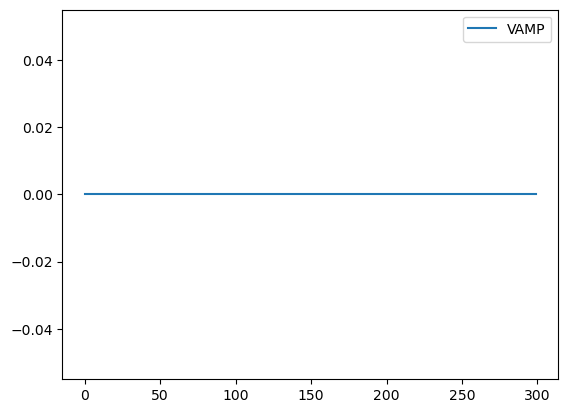

In [27]:
plt.plot(vm1[0], label = 'VAMP')
'''plt.plot(vm2, label = 'VAMP2')
plt.plot(-vm3, label = 'loss')
plt.plot(tm1, label = 'training VAMP')
plt.plot(tm2, label = 'training VAMP2')
plt.plot(-tm3, label = 'training loss')'''
plt.legend()
plt.savefig("losses.png")
plt.show()

In [46]:
# Transform the input trajectory using the network
states_prob = model.predict([traj_ord, traj_ord_lag])[:, :output_size]

# Order the output states based on their population
coor_pred = np.argmax(states_prob, axis = 1)
indexes = [np.where(coor_pred == np.multiply(np.ones_like(coor_pred), n)) for n in range(output_size)]
states_num = [len(i[0]) for i in indexes]
states_order = np.argsort(states_num).astype('int')[::-1]

pred_ord = states_prob[:,states_order]
pred_ord = np.round(pred_ord, decimals = 3)

# Visualize the population of the states

2_states_E10_peptides_input_   States population: [50.29684161 49.72690572]%


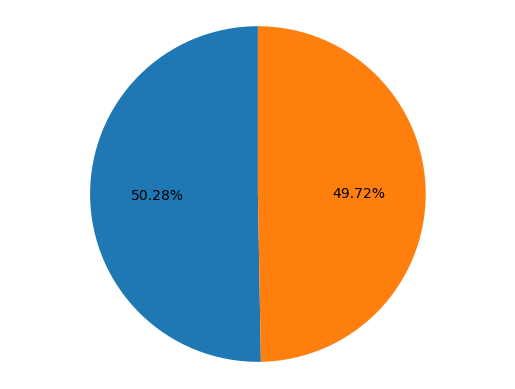

2_states_E10_peptides_input_   Stable vector:  [51.63256  48.367443] %


<Figure size 640x480 with 0 Axes>

In [47]:
tau_msm = 35

def print_states_pie_chart():
    coors = []
    maxi = np.max(pred_ord, axis= 1)

    for i in range(output_size):
        coors.append(len(np.where(pred_ord[:,i] == maxi)[0]))
        
    fig1, ax1 = plt.subplots()
    ax1.pie(np.array(coors), autopct='%1.2f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    print(model_name + '   States population: '+str(np.array(coors)/len(maxi)*100)+'%')
    plt.show()
    plt.savefig("states_population.png")

print_states_pie_chart()

#note: the matrix is row stochastic.
#A markov chain transition will correspond to left multiplying by a row vector.
K_smt_nonmeanfree = vamp.estimate_koopman_op(pred_ord, tau_msm)
Q = K_smt_nonmeanfree

#We have to transpose so that Markov transitions correspond to right multiplying by a column vector.  np.linalg.eig finds right eigenvectors.
evals, evecs = np.linalg.eig(Q.T)
evec1 = evecs[:,np.isclose(evals, 1)]

#Since np.isclose will return an array, we've indexed with an array
#so we still have our 2nd axis.  Get rid of it, since it's only size 1.
evec1 = evec1[:,0]

stationary = evec1 / evec1.sum()

#eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
stationary = stationary.real

print(model_name + "   Stable vector: ", stationary * 100, "%");

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


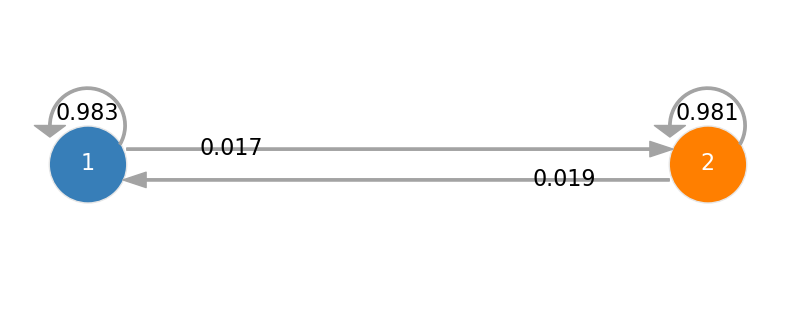

In [48]:
%load_ext autoreload
%autoreload 2

tau_msm = 5

K_smt_nonmeanfree = vamp.estimate_koopman_op(pred_ord, tau_msm)
K_smt_nonmeanfree = np.round(K_smt_nonmeanfree, decimals = 3)
import numpy as np
import matplotlib.pyplot as plt 
# Import the MarkovChain class from markovchain.py
from markovchain import MarkovChain


nodes_facecolor = ['#377eb8', '#ff7f00']
mc = MarkovChain(K_smt_nonmeanfree, ['1', '2'], nodes_facecolor = nodes_facecolor)
mc.draw()

# Markov Model Estimation

# Estimate the implied timescales

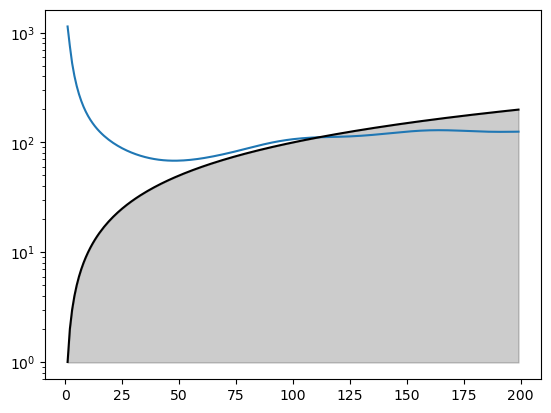

In [22]:
max_tau = 200
lag = np.arange(1, max_tau, 1)
its = vamp.get_its(pred_ord, lag)
vamp.plot_its(its, lag)

# Chapman-Kolmogorov test for the estimated koopman operator

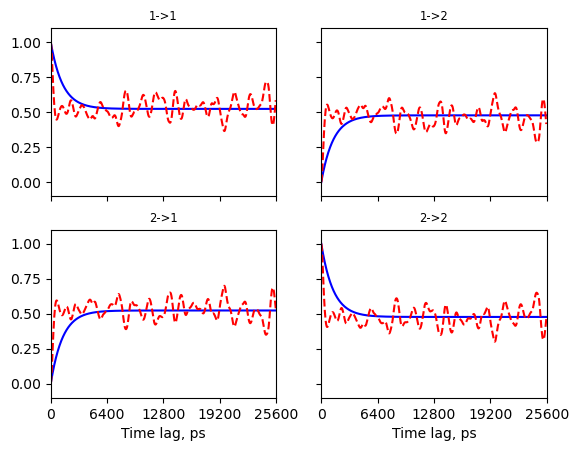

In [57]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

def custom_plot_ck_test(pred, est, n_states, steps, tau):
        '''Plots the result of the Chapman-Kolmogorov test calculated by the function
        'get_ck_test'
        Parameters
        ----------
        pred: numpy array
        est: numpy array
            pred, est are the two arrays returned by the function get_ck_test
        n_states: int
        steps: int
        tau: int
            values used for the Chapman-Kolmogorov test as parameters in the function
            get_ck_test
        '''
        
        fig, ax = plt.subplots(n_states, n_states, sharex=True, sharey=True)
        for index_i in range(n_states):
            for index_j in range(n_states):
                
                ax[index_i][index_j].plot(np.arange(0, steps*tau, tau) * picoseconds_per_step
                                          ,pred[index_i, index_j], color='b')
                
                ax[index_i][index_j].plot(np.arange(0, steps*tau, tau) * picoseconds_per_step
                                          ,est[index_i, index_j], color='r', linestyle='--')
                
                ax[index_i][index_j].set_title(str(index_i+1)+ '->' +str(index_j+1),
                                               fontsize='small')
        
        ax[0][0].set_ylim((-0.1,1.1));
        ax[0][0].set_xlim((0, steps*tau));
        
        ax[0][0].axes.get_xaxis().set_ticks(np.round(np.linspace(0, steps*tau, 5)) * picoseconds_per_step);#(np.round(np.linspace(0, steps*tau, 5)));
        #ax[0][0].axes.get_xaxis().set_ticks(np.round(np.linspace(0, steps*tau, 5)));
        
        
        # -------------------------------------------
        
        
        ax[1][1].axes.set_xlabel("Time lag, ps")
        ax[1][0].axes.set_xlabel("Time lag, ps")
        
        #ax[1][1].axes.set_xlabel("time lag, steps")
        #ax[1][1].axes.set_xlabel("time lag, steps")
        
        '''ax2 = ax[0][0].twiny()
        ax2.set_xlabel("x-transformed")
        ax2.set_xlim(0, 60)'''
        #ax2.set_xticks(np.arange(0, steps*tau, tau) * picoseconds_per_step)
        
        plt.show()
        

steps = 2**9 #2**4 or 2**9
predicted, estimated = vamp.get_ck_test(pred_ord, steps, tau_msm)
custom_plot_ck_test(predicted, estimated, output_size, steps, tau_msm)

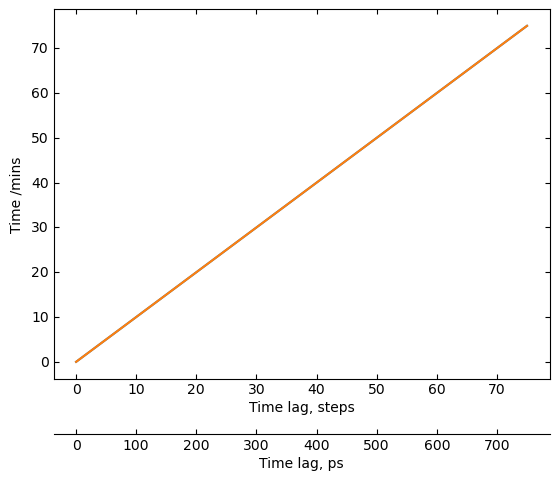

In [124]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

y = np.arange(0, steps*tau_msm, tau_msm)
x = [np.arange(0, steps*tau_msm, tau_msm), np.arange(0, steps*tau_msm, tau_msm) * picoseconds_per_step]
labels = ['m/s', 'km/hr']

fig = plt.figure()
# generate the first axis
ax = host_subplot(111, axes_class = AA.Axes, figure = fig)
ax.plot(x[0], y)
ax.set_xlabel("Time lag, steps")
ax.set_ylabel("Time /mins")

ax2=ax.twiny()

# make space for the secondary axis
plt.subplots_adjust(bottom = 0.2)

# set position ax2 axis
offset = -40
new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
ax2.axis['bottom'] = new_fixed_axis(loc = 'bottom',
                                    axes = ax2,
                                    offset = (0, offset))
ax2.axis['bottom'].toggle(all = True)

ax2.plot(x[1], y)
ax2.set_xlabel("Time lag, ps")
plt.show()

In [123]:
np.round(np.linspace(0, steps*tau_msm, 5))

array([ 0., 20., 40., 60., 80.])

In [116]:
steps*tau

16